# EEG Complexity Analysis

This example can be referenced by [citing the package](https://github.com/neuropsychology/NeuroKit#citation).

**This example is not ready. We need your help to help us create an example on how to do complexity analysis EEG data!**

Actually, this example is totally exploratory and tries to apply a new exploratory index (fractal density) to EEG data. Do not take it seriously!

In [90]:
# Load packages
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import neurokit2 as nk

In [91]:
# Note: this cell is hidden using the "remove-input" tag
# Make bigger images
plt.rcParams['figure.figsize'] = [15, 5]  
plt.rcParams['font.size']= 14

## Data Preprocessing

Load and format the EEG data of one participant following this [MNE example](https://mne.tools/dev/auto_tutorials/evoked/30_eeg_erp.html).


In [92]:
# Load raw EEG data
raw = nk.data("eeg_1min_200hz")

# Find events and map them to a condition
events = mne.find_events(raw, stim_channel='STI 014', verbose=False)
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'face': 5, 'buttonpress': 32}

# Select only relevant channels
raw = raw.pick(['eeg', 'eog'], verbose=False)

# Store sampling rate
sampling_rate = raw.info["sfreq"]

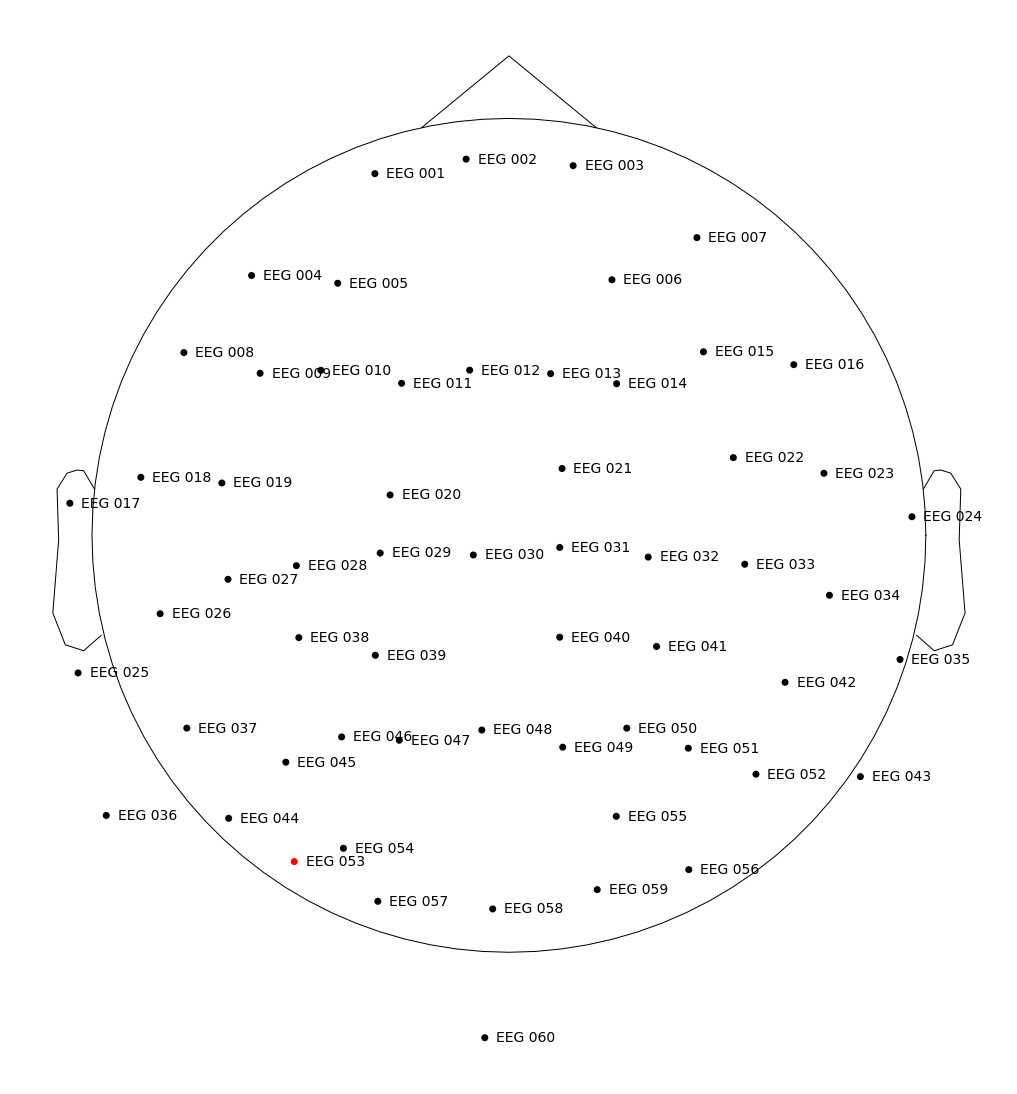

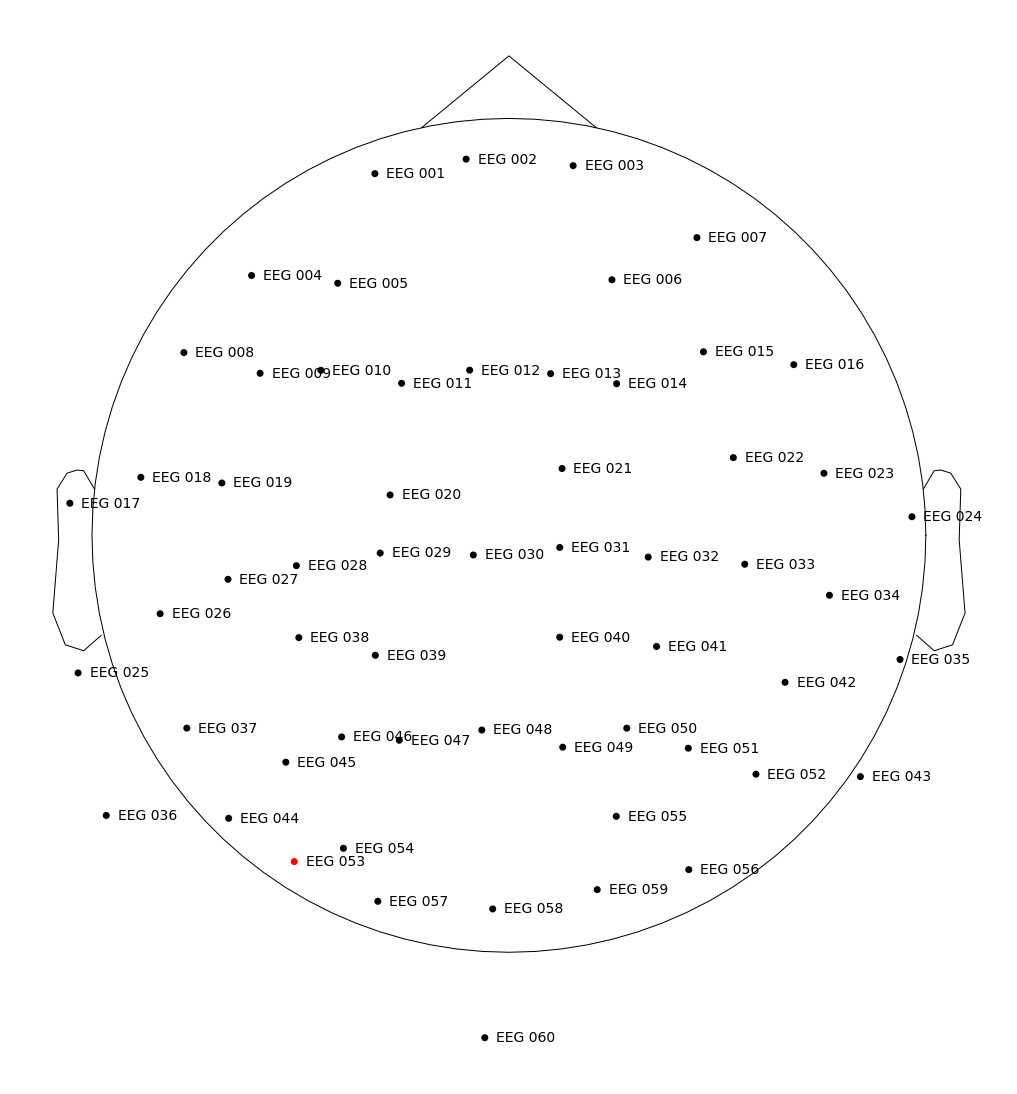

In [93]:
raw = raw.filter(l_freq=0.1, h_freq=40,verbose=False)
raw.plot_sensors(show_names=True)

We will now create **epochs** around each event, and reject some based on extreme values.

In [94]:
epochs = mne.Epochs(raw, 
                    events, 
                    event_id=event_dict, 
                    tmin=-0.3, 
                    tmax=0.7, 
                    preload=True, 
                    verbose=False)

# Reject epochs by providing maximum peak-to-peak signal value thresholds
epochs = epochs.drop_bad(reject= dict(eeg=100e-6, eog=200e-6), verbose=False)  # 100 µV, 200 µV

We will pick 4 fronto-central channels of interests (namely *EEG 011-014*), that we can visualize as follows: 

No projector specified for this dataset. Please consider the method self.add_proj.


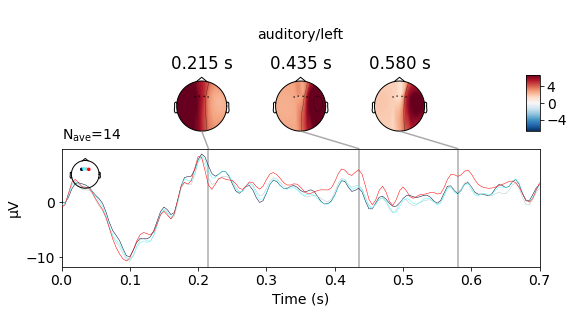

No projector specified for this dataset. Please consider the method self.add_proj.


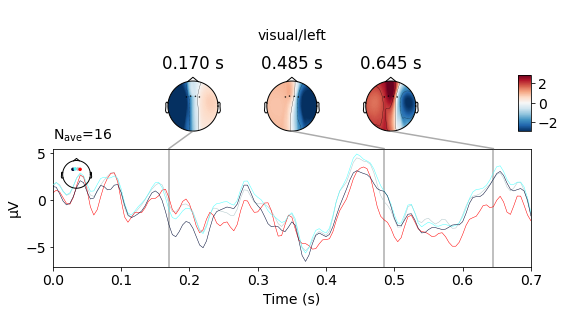

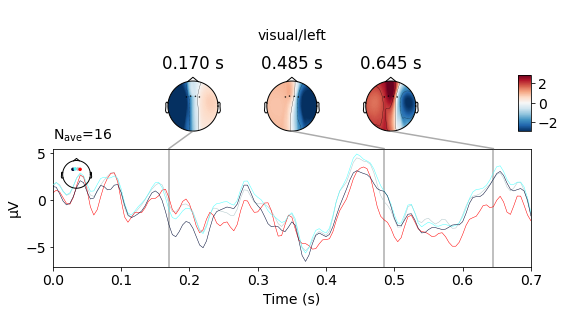

In [95]:
# Channels of interest
channels = ["EEG 011", "EEG 012", "EEG 013", "EEG 014"]
# channels = ["EEG 0" + str(i) for i in range(11, 15)]  # Alternative


auditory = epochs['auditory/left'].pick_channels(channels).crop(tmin=0)
visual = epochs['visual/left'].pick_channels(channels).crop(tmin=0)

auditory.average().plot_joint(title='auditory/left')
visual.average().plot_joint(title='visual/left')

Now we are going to convert the data to a Pandas dataframe and concatenate the two groups of epochs. Next, we are going to average together the EEG channels.

In [96]:
df = pd.concat([auditory.to_data_frame(),
               visual.to_data_frame()])

df["EEG"] = df[channels].mean(axis=1)

df.head()

,time,condition,epoch,EEG 011,EEG 012,EEG 013,EEG 014,EEG
0,0.000,auditory/left,2,-4.414247,-3.515468,-0.330308,3.829678,-1.107586
1,0.005,auditory/left,2,-2.360910,-0.880196,1.669160,4.023423,0.612870
2,0.010,auditory/left,2,0.815137,2.031109,4.031405,6.675097,3.388187
3,0.015,auditory/left,2,1.605833,2.434812,4.953165,9.598465,4.648069
4,0.020,auditory/left,2,-0.559503,0.475777,3.917993,10.289093,3.530840


## Complexity Analysis

Many complexity metrics require some parameters to be specified. For the "delay", a good value could be 27 ms, that we need to convert into a number of samples.

In [97]:
delay = int(27 / (1000 / sampling_rate))  # 27 is the delay in milliseconds

### Event-related Attractors

Let's visualize the attractors of the averaged events. We will then compute the complexity metrics for each epoch separately.

Text(0.5, 1.0, 'Event-related Attractors')

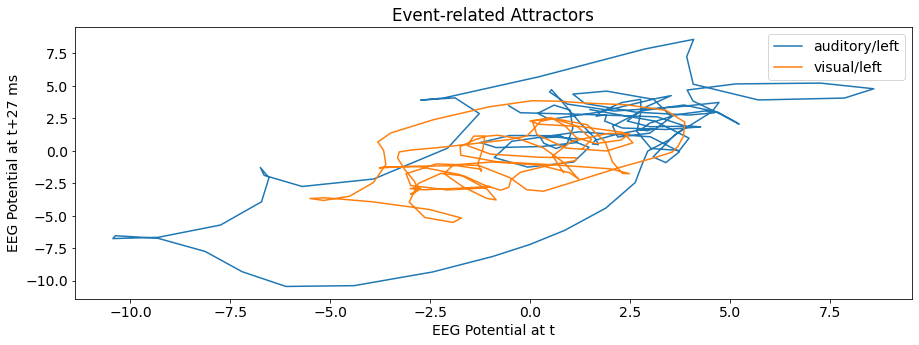

In [98]:
df_event = df.groupby(["time", "condition"], as_index=False).mean()

for cond in ["auditory/left", "visual/left"]:
    signal = df_event[df_event["condition"] == cond]["EEG"]
    attractor = nk.complexity_embedding(signal, delay=delay, dimension=2)
    plt.plot(attractor[:, 0], attractor[:, 1], label=cond)
plt.legend()
plt.xlabel("EEG Potential at t")
plt.ylabel("EEG Potential at t+27 ms")
plt.title("Event-related Attractors")

### Compute complexity indices per epoch

In [99]:
def get_sdvden(x):
    rez, _ = nk.entropy_svd(x["EEG"], delay=delay, dimension=3)
    return pd.Series({'SVDEn': rez})

def get_hjorth(x):
    rez, _ = nk.entropy_svd(x["EEG"])
    return pd.Series({'Hjorth': rez})


results = pd.merge(
    df.groupby(["condition", "epoch"], as_index=False).apply(get_sdvden), 
    df.groupby(["condition", "epoch"], as_index=False).apply(get_hjorth)
)

results.head()

,condition,epoch,SVDEn,Hjorth
0,auditory/left,2,1.415754,0.576404
1,auditory/left,6,1.402700,0.484591
2,auditory/left,10,1.442964,0.614160
3,auditory/left,14,1.451905,0.588377
4,auditory/left,19,1.392537,0.535773


Lets' run some t-tests on these indices.

In [100]:
scipy.stats.ttest_ind(results[results["condition"] == "auditory/left"]["SVDEn"], 
                      results[results["condition"] == "visual/left"]["SVDEn"], 
                      equal_var=False)

scipy.stats.ttest_ind(results[results["condition"] == "auditory/left"]["Hjorth"], 
                      results[results["condition"] == "visual/left"]["Hjorth"], 
                      equal_var=False)

Ttest_indResult(statistic=0.38214400826687783, pvalue=0.7055440395078612)

We can visualize these differences like follows:

<AxesSubplot:xlabel='variable', ylabel='value'>

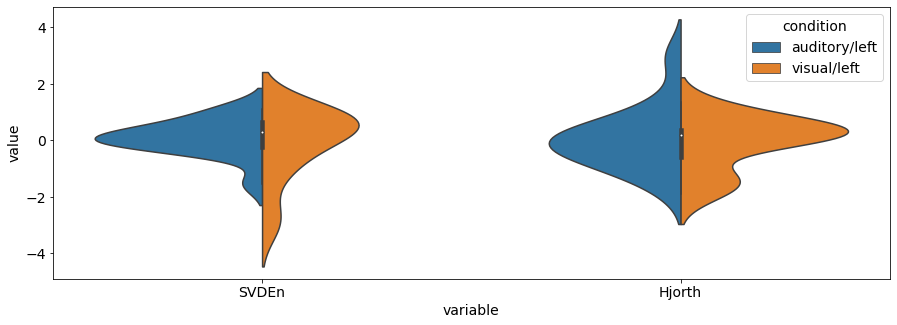

In [101]:
# Standardize
results[['SVDEn', 'Hjorth']] = nk.standardize(results[['SVDEn', 'Hjorth']])

# Pivot to long format
results_long = pd.melt(results, id_vars=['condition', "epoch"], value_vars=['SVDEn', 'Hjorth'])

# Plot results
sns.violinplot(data=results_long, x="variable", y="value", hue="condition", split=True)

### Fractal Density

**Note: this index is totally exploratory and is mentioned here as part of a WIP development.**

Now, we will average the signal of those 4 channels for each epoch and store them in a dictionary. 


DFD1 = 3.679826749445238, DFD2 = 2.9874001096501495


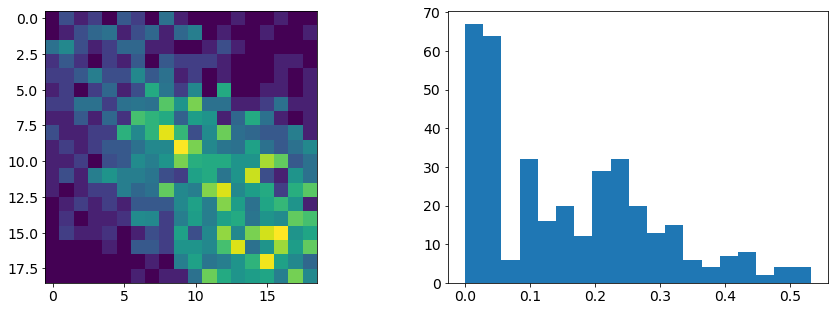

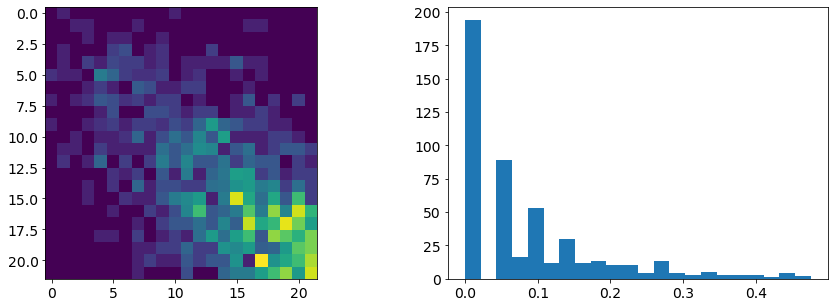

In [102]:
epochs_auditory = {str(i + 1): pd.DataFrame({"Signal": epoch.mean(axis=0)}) for i, epoch in enumerate(auditory)}
epochs_visual = {str(i + 1): pd.DataFrame({"Signal": epoch.mean(axis=0)}) for i, epoch in enumerate(visual)}

dfd1, _ = nk.fractal_density(epochs_auditory, delay=int(delay), show=True)
dfd2, _ = nk.fractal_density(epochs_visual, delay=int(delay), show=True)

print(f"DFD1 = {dfd1}, DFD2 = {dfd2}")